# LinUCB Disjoint

In [111]:
import numpy as np
import matplotlib.pyplot as plt

In [112]:
import pandas as pd

In [113]:
def process_data(path):
    df = pd.read_csv(path)
    df = pd.get_dummies(df, columns = [f'user_feature_{i}' for i in range(4)])
    #df = df[df.columns.drop(list(df.filter(regex='affinity')))]
    d = len(df.filter(regex = "feature").columns) + len(df.filter(regex = "affinity").columns)
    print(f'Number of features = {d}')
    print(f'Number of arms = {max(df["item_id"]) + 1}')

    return df, d, max(df["item_id"] + 1)


In [114]:
# Create class object for a single linear ucb disjoint arm
class linucb_disjoint_arm():
    
    def __init__(self, arm_index, d, alpha):
        
        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = np.identity(d)
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])
        
    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression
        A_inv = np.linalg.inv(self.A)
        
        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta is (d x 1) dimension vector
        self.theta = np.dot(A_inv, self.b)
        
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        # Find ucb based on p formulation (mean + std_dev) 
        # p is (1 x 1) dimension vector
        p = np.dot(self.theta.T,x) +  self.alpha * np.sqrt(np.dot(x.T, np.dot(A_inv,x)))
        
        return p
    
    def reward_update(self, reward, x_array):
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        # Update A which is (d * d) matrix.
        self.A += np.dot(x, x.T)
        
        # Update b which is (d x 1) vector
        # reward is scalar
        self.b += reward * x 

In [115]:
class linucb_policy():
    
    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha) for i in range(K_arms)]


    def topk_by_partition(self, array, k, axis=None, ascending=True):
        if not ascending:
            array *= -1
        ind = np.argpartition(array, k, axis=axis)
        ind = np.take(ind, np.arange(k), axis=axis) # k non-sorted indices
        array = np.take_along_axis(array, ind, axis=axis) # k non-sorted values

        # sort within k elements
        ind_part = np.argsort(array, axis=axis)
        ind = np.take_along_axis(ind, ind_part, axis=axis)
        if not ascending:
            input *= -1
        val = np.take_along_axis(array, ind_part, axis=axis) 
        return ind, val
        
    def select_arm(self, x_array, n_top=3):
        """
        Select the top n arms based on UCB values.
        
        Args:
            x_array: Input features
            n_top: Number of top arms to return (default=3)
        
        Returns:
            list: Top n arms indices
            list: Corresponding UCB values
        """
        # Calculate UCB for all arms
        ucb_values = []
        for arm_index in range(self.K_arms):
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)
            ucb_values.append((arm_index, arm_ucb))

        top_arms, top_ucb_values = self.topk_by_partition(x_array, n_top)
        
        return top_arms, top_ucb_values

In [116]:
def ctr_simulator(K_arms, d, alpha, df):
    # Initiate policy
    linucb_policy_object = linucb_policy(K_arms = K_arms, d = d, alpha = alpha)
    
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    for idx, row in df.iterrows():

        # 1st column: Logged data arm. 
        # Integer data type
        data_arm = row['item_id']

        # 2nd column: Logged data reward for logged chosen arm
        # Float data type
        data_reward = row['click']

        # 3rd columns onwards: 100 covariates. Keep in array of dimensions (100,) with float data type
        #covariate_string_list = row[[f'user-item_affinity_{i}' for i in range(1,80)]]
        covariate_string_list = np.concatenate((row.filter(regex = "feature").to_numpy(), row.filter(regex = "affinity").to_numpy()), axis = 0)
        data_x_array = np.array([float(covariate_elem) for covariate_elem in covariate_string_list])

        # Find policy's chosen arm based on input covariates at current time step
        arms, _ = linucb_policy_object.select_arm(data_x_array)

        # Check if arm_index is the same as data_arm (ie same actions were chosen)
        # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.

        if data_arm in arms:

            # Use reward information for the chosen arm to update
            linucb_policy_object.linucb_arms[data_arm-1].reward_update(data_reward, data_x_array)

            # For CTR calculation
            aligned_time_steps += 1
            cumulative_rewards += data_reward
            aligned_ctr.append(cumulative_rewards/aligned_time_steps)
                    
    return (aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object)

In [104]:
alpha_input = 1.5
data_path = "obd/bts/men/men.csv"
df = process_data(data_path)

Number of features = 65
Number of arms = 34


In [ ]:
randlist = pd.DataFrame(index=np.random.randint(10000, size=10000))
df.merge(randlist, left_index=True, right_index=True, how='right')

266 ms ± 9.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
alpha_input = 1.5
data_path = "obd/bts/men/men.csv"
df, d, K_arms = process_data(data_path)
aligned_ctrs = []
for i in range(100):
    randlist = pd.DataFrame(index=np.random.randint(10000, size=10000))
    df_temp = df.merge(randlist, left_index=True, right_index=True, how='right')
    aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = K_arms, d = d, alpha = alpha_input, df = df_temp)
    aligned_ctrs.append(aligned_ctr)


Number of features = 65
Number of arms = 34


KeyboardInterrupt: 

In [110]:
aligned_ctrs

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


Text(0.5, 1.0, 'alpha = 1.5')

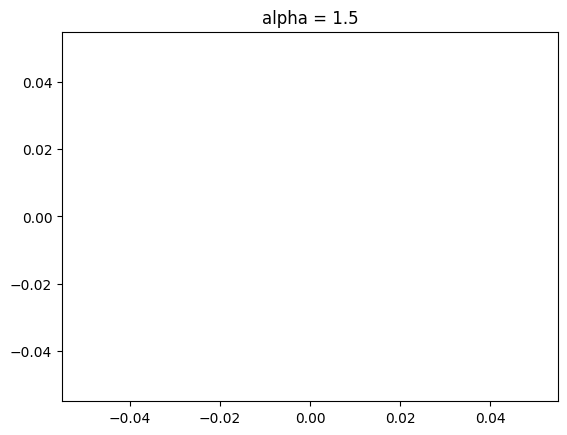

In [89]:
plt.plot(aligned_ctr)
plt.title("alpha = " + str(alpha_input))

Text(0.5, 1.0, 'alpha = 1.5')

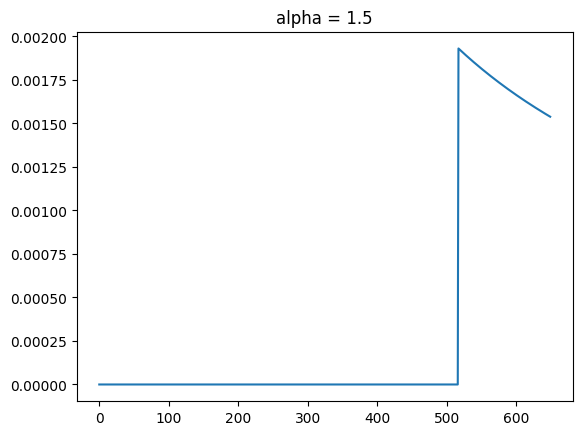

In [67]:
plt.plot(aligned_ctr)
plt.title("alpha = " + str(alpha_input))

Text(0.5, 1.0, 'alpha = 1.0')

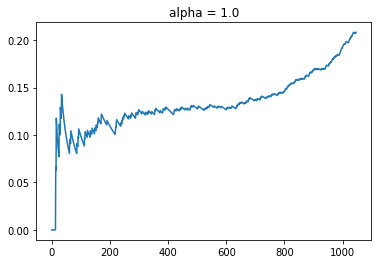

In [8]:
alpha_input = 1.0
data_path = "../data/news_dataset.txt"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 10, d = 100, alpha = alpha_input, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))

Text(0.5, 1.0, 'alpha = 0.5')

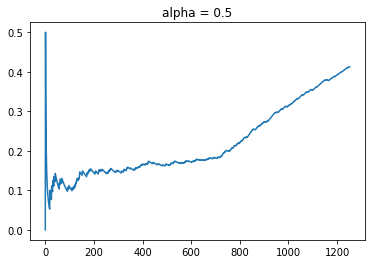

In [9]:
alpha_input = 0.5
data_path = "../data/news_dataset.txt"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 10, d = 100, alpha = alpha_input, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))